# Plota dados da Janis da boia WAVESCAN do SIODOC
- Henrique P. P. Pereira
- Hanna Luizete
- Carlos E Parente

In [14]:
import os
import pandas as pd
import matplotlib
import matplotlib.pylab as pl
import numpy as np
import scipy.io
from datetime import datetime
import waveproc
matplotlib.reload(waveproc)
% matplotlib inline

In [15]:
#carrega dados processados - Janis

pathnamep = os.environ['HOME'] + '/Dropbox/database/historical/buoys/siodoc/arraial/proc/'

dateparse = lambda x: pd.datetime.strptime(x, '%d %m %Y %H %M %S')

janis = pd.read_table(pathnamep + 'janis_data.dat', sep='\s+', parse_dates=[[0,1,2,3,4,5]], header=None, date_parser=dateparse, index_col=['0_1_2_3_4_5'])

dd = janis.ix[:,[7,27,28,29,30,38,39,40,57,59,66,67,67]]

dd.columns = ['ate','hm0','hm0a','hm0b','hmax','mdir','mdira','mdirb','tp','wt','wd','ws','wg']

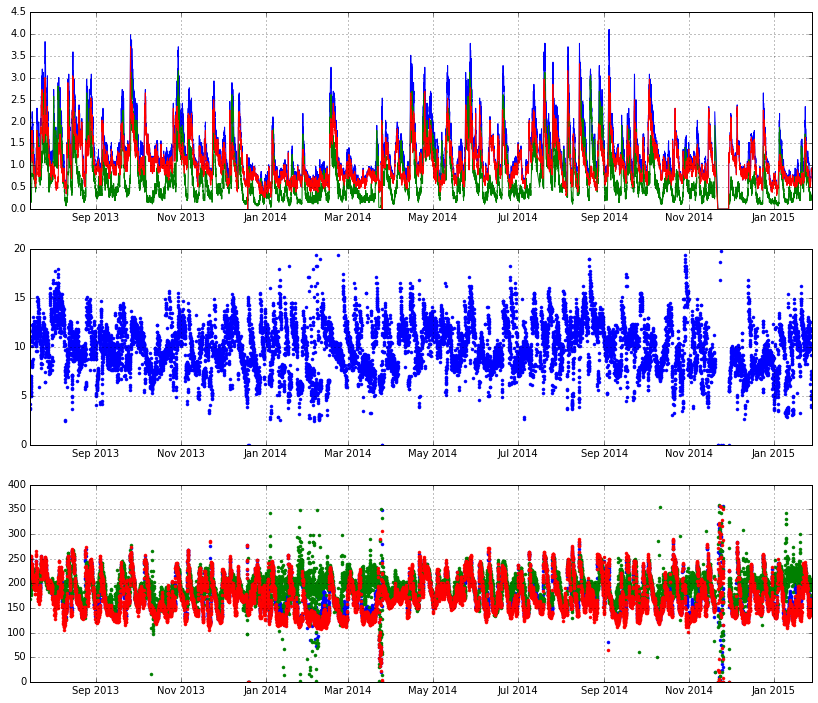

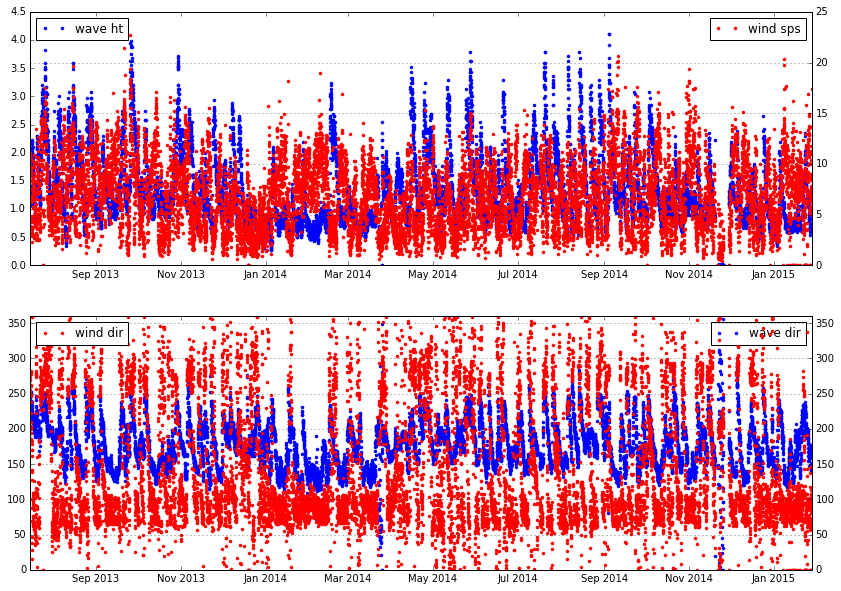

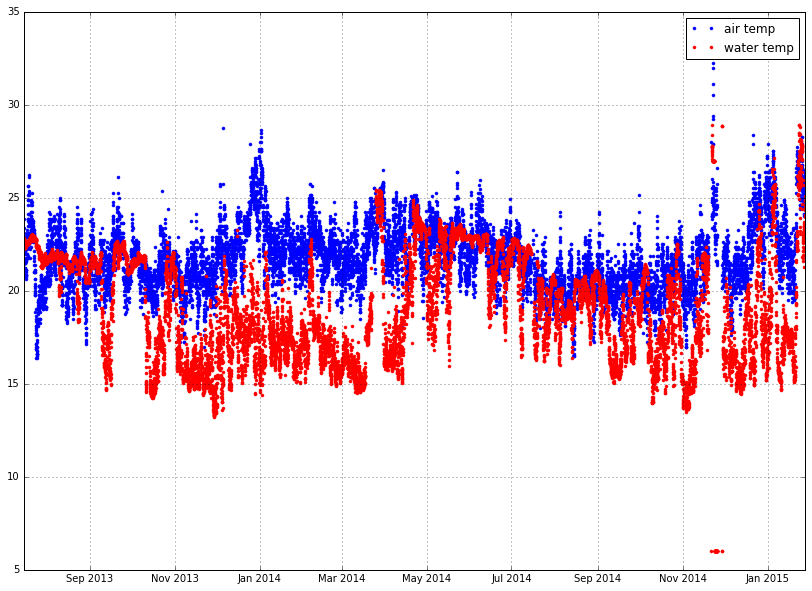

In [16]:
#onda

pl.figure(figsize=(14,12))
pl.subplot(311)
pl.plot(dd.index, dd.hm0)
pl.plot(dd.index, dd.hm0a)
pl.plot(dd.index, dd.hm0b)
pl.grid()
pl.subplot(312)
pl.plot(dd.index, dd.tp,'.')
pl.ylim(0,20)
pl.grid()
pl.subplot(313)
pl.plot(dd.index, dd.mdir,'.')
pl.plot(dd.index, dd.mdira,'.')
pl.plot(dd.index, dd.mdirb,'.')
pl.grid()

#onda/vento

pl.figure(figsize=(14,10))
pl.subplot(211)
pl.plot(dd.index, dd.hm0,'b.', label='wave ht')
pl.legend(loc=2), pl.twinx(), pl.grid()
pl.plot(dd.index, dd.ws,'r.', label='wind sps')
pl.legend(loc=1)
pl.subplot(212)
pl.plot(dd.index, dd.mdir,'b.', label='wave dir')
pl.legend(loc=1), pl.ylim(0,360)
pl.twinx(), pl.grid()
pl.plot(dd.index, dd.wd,'r.', label='wind dir')
pl.legend(loc=2), pl.ylim(0,360)
pl.savefig('ondavento.png')

#temperatura do ar e da agua

pl.figure(figsize=(14,10))
pl.plot(dd.index, dd.ate,'b.', label='air temp')
pl.plot(dd.index, dd.wt,'r.', label='water temp')
pl.grid()
pl.legend()


# Processamento dos dados brutos de ondas da boia do SIODOC utilizando a classe waveproc
- Henrique P. P. Pereira

In [17]:
#carrega dados brutos de ondas

pathname = os.environ['HOME'] + '/Dropbox/database/historical/buoys/siodoc/arraial/raw/'

#carrega arquivos .mat
hvmat = scipy.io.loadmat(pathname + 'heave.mat')
ptmat = scipy.io.loadmat(pathname + 'pitch.mat')
rlmat = scipy.io.loadmat(pathname + 'roll.mat')
cpmat = scipy.io.loadmat(pathname + 'compass.mat')

#retira as datas
hv1 = hvmat['heave'][:,6:]
pt1 = ptmat['pitch'][:,6:]
rl1 = rlmat['roll'][:,6:]
cp1 = cpmat['compass'][:,6:]

#data de todos os arquivos com datetime
data_all = hvmat['heave'][:,[0,1,2,3,4,5]]
datat_all = [datetime(int(data_all[i,0]),int(data_all[i,1]),int(data_all[i,2]),int(data_all[i,3])) for i in range(len(data_all))]
datat1 = np.array(datat_all) 

#create dataframe - pandas
hv = pd.DataFrame(hv1, index=datat1)
pt = pd.DataFrame(pt1, index=datat1)
rl = pd.DataFrame(rl1, index=datat1)
cp = pd.DataFrame(cp1, index=datat1)

In [18]:
#correcao do compass (NDBC 96, pg.14) - faz a correcao de pitch e roll em slpEW e slpNS

# valores do compass em radianos
cp_rad = cp * (np.pi/180)

#?? teste
cp_rad = np.arctan(np.sin(cp_rad) / np.cos(cp_rad))

#pitch
pitch_EW = ( (np.sin(cp_rad) * np.sin(pt)) / np.cos(pt) ) -  ( (np.cos(cp_rad) * np.sin(rl)) / (np.cos(pt) * np.cos(rl)) )

#roll
roll_NS = ( (np.cos(cp_rad) * np.sin(pt)) / np.cos(pt) ) +  ( (np.sin(cp_rad) * np.sin(rl)) / (np.cos(pt) * np.cos(rl)) )

pt = pitch_EW
rl = roll_NS

In [19]:
#processamento

w = waveproc.WaveProc(pathname)

w.h = 60
w.fs = 1.0
w.dt = 1 / w.fs
w.nfft = 64

dd1 = []
for i in range(len(hv)):
    
    w.date = datat1[i]
    w.n1 = hv.ix[i]
    w.n2 = pt.ix[i]
    w.n3 = rl.ix[i]
    
    w.timedomain()
    w.freqdomain()
    
    dd1.append({'date'   : w.date,
               'hs'     : w.hs,
               'h10'    : w.h10,
               'hmax'   : w.hmax,
               'tmed'   : w.tmed,
               'thmax'  : w.thmax,
               'hm0'    : w.hm0,
               'tp'     : w.tp,
               'dp'     : w.dp,
               'tzamax' : w.tzamax})
    
dd1 = pd.DataFrame(dd1)
dd1 = dd1.set_index('date')

KeyboardInterrupt: 

In [ ]:
#plotagem dados brutos

pl.figure(figsize=(14,12))
pl.subplot(311)
pl.plot(dd1.index, dd1.hm0)
pl.grid()
pl.subplot(312)
pl.plot(dd1.index, dd1.tp,'.')
pl.ylim(0,20)
pl.grid()
pl.subplot(313)
pl.plot(dd1.index, dd1.dp,'.')
pl.grid()

# Plota comparacao do bruto e reprocessado do SIODOC

In [ ]:
#plotagem bruto e reprocessado

dd = dd['2014-10']
dd1 = dd1['2014-10']

pl.figure(figsize=(14,12))
pl.subplot(311)
pl.plot(dd.index, dd.hm0, label='proc')
pl.plot(dd1.index, dd1.hm0, label='reproc')
pl.grid(), pl.legend()
pl.subplot(312)
pl.plot(dd.index, dd.tp,'.')
pl.plot(dd1.index, dd1.tp,'.')
pl.ylim(0,20)
pl.grid()
pl.subplot(313)
pl.plot(dd.index, dd.mdir,'.')
pl.plot(dd1.index, dd1.dp,'.')
pl.grid()

pl.savefig('comparacao_proc_reproc.png')

# Processamento dos dados de Ilha Rasa - Sensor GX3


In [ ]:
pathname = os.environ['HOME'] + '/Dropbox/database/historical/buoys/lts/ilharasa_hanna/'

aew = pd.read_csv(pathname + 'TOA5_61689.microstrain_stbaclEW.dat', 
    skiprows=4, header=None, index_col=0, parse_dates=True)

ans = pd.read_csv(pathname + 'TOA5_61689.microstrain_stbaclNS.dat', 
    skiprows=4, header=None, index_col=0, parse_dates=True)

av = pd.read_csv(pathname + 'TOA5_61689.microstrain_stbaclV.dat', 
    skiprows=4, header=None, index_col=0, parse_dates=True)

#remove uma coluna que nao faz parte da serie temporal
aew = aew.drop(aew.columns[0], axis=1)
ans = ans.drop(ans.columns[0], axis=1)
av = av.drop(av.columns[0], axis=1)

In [ ]:
#processamento

w = waveproc.WaveProc(pathname)

w.h = 60
w.fs = 1.0
w.dt = 1 / w.fs
w.nfft = 128

dd = []
for i in range(len(av)):
    
#     print (av.index[i])
    
    w.date = av.index[i]
    w.n1 = av.ix[i]
    w.n2 = ans.ix[i]
    w.n3 = aew.ix[i]
    
#     w.timedomain()
    w.freqdomain()
    
    dd.append({'date'   : w.date,
#                'hs'     : w.hs,
#                'h10'    : w.h10,
#                'hmax'   : w.hmax,
#                'tmed'   : w.tmed,
#                'thmax'  : w.thmax,
               'hm0'    : w.hm0,
               'tp'     : w.tp,
               'dp'     : w.dp,
#                'tzamax' : w.tzamax
              })
    
dd = pd.DataFrame(dd)
dd = dd.set_index('date')

In [ ]:
pl.figure(figsize=(14,12))
pl.subplot(311)
pl.plot(dd.index, dd.hm0)
pl.grid()
pl.subplot(312)
pl.plot(dd.index, dd.tp,'.')
pl.grid()
pl.subplot(313)
pl.plot(dd.index, dd.dp,'.')
pl.grid()

dd = dd['2014-10']
dd1 = dd1['2014-10']

pl.figure(figsize=(14,12))
pl.subplot(311)
pl.plot(dd.index, dd.hm0, label='proc')
pl.plot(dd1.index, dd1.hm0, label='reproc')
pl.grid(), pl.legend()
pl.subplot(312)
pl.plot(dd.index, dd.tp,'.')
pl.plot(dd1.index, dd1.tp,'.')
pl.ylim(0,20)
pl.grid()
pl.subplot(313)
pl.plot(dd.index, dd.mdir,'.')
pl.plot(dd1.index, dd1.dp,'.')
pl.grid()


pl.show()

# Plot comparando SIODOC (bruto e proc) e Ilha Rasa

In [ ]:
pl.figure(figsize=(14,12))


#plotagem bruto e reprocessado


pl.savefig('comparacao_proc_reproc.png')